### Bibliotecas

In [12]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [14]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [15]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [17]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [18]:
dataset_dados['horario'] = dataset_dados['horario'].fillna('99:99:99')

In [19]:
dataset_dados = dataset_dados.assign(dia_semana=dataset_dados['data'].dt.weekday, hora=dataset_dados['horario'].astype('str').str.slice(stop=2).astype('int').replace({99:np.nan}),
                     minuto=dataset_dados['horario'].astype('str').str.slice(start=3, stop=5).astype('int').replace({99:np.nan}))
dataset_dados['horario'] = dataset_dados['horario'].replace({'99:99:99':np.nan})

In [20]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [21]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [23]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [24]:
dataset_dados = dataset_dados.assign(resultado_partida=dataset_dados['resultado_temporario'].map(lambda x: 0 if x == 0 else 1 if x > 0 else -1))

In [25]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [26]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [28]:
#RESULTADOS CONSECUTIVOS

dataset_consec = dataset_dados['resultado_partida'].shift(5, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_consec[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

dataset_ultimo = dataset_dados['resultado_partida'].shift(1, fill_value=0)

for i in range(len(dataset_dados)):
    valor = dataset_ultimo[i:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

del dataset_consec, dataset_ultimo

##### Gols, Colocação e Time Adversário

In [30]:
dataset_dados.loc[:,['gols_botafogo','colocacao_botafogo','colocacao_adversario','time_adversario']] = dataset_dados.apply(lambda d: d[['gols_mandante','colocacao_mandante','colocacao_visitante','time_visitante']].rename(index={'gols_mandante':'gols_botafogo','colocacao_mandante':'colocacao_botafogo','colocacao_visitante':'colocacao_adversario','time_visitante':'time_adversario'})
                            if d['time_mandante'] == 'Botafogo' 
                            else d[['gols_visitantes','colocacao_visitante','colocacao_mandante','time_mandante']].rename(index={'gols_visitantes':'gols_botafogo','colocacao_visitante':'colocacao_botafogo','colocacao_mandante':'colocacao_adversario','time_mandante':'time_adversario'}), axis=1)

In [31]:
dataset_gols = dataset_dados['gols_botafogo'].shift(5, fill_value=0)
for i in range(len(dataset_dados)):
    valor = dataset_gols[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor
del dataset_gols

##### Percentual de Ocupacao

In [33]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [35]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [36]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [38]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [40]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [42]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

##### Distância dos Dias entre o Último Jogo em Casa

In [44]:
dataset_dados['data_ultimo_jogo'] = dataset_dados['data'].shift(1)

In [45]:
dataset_dados.loc[0,'data_ultimo_jogo'] = pd.to_datetime('2022-03-07')

In [46]:
dataset_dados.loc[:, 'dias_ultimo_jogo_casa'] = (dataset_dados['data'] - dataset_dados['data_ultimo_jogo']).dt.days

##### Tratamentos

In [48]:
len(dataset_dados)

126

In [49]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida', 'publico',
       'publico_max', 'arrecadacao', 'despesas', 'impostos',
       'resultado_financeiro', 'custo_botafogo', 'anunciou_poupar',
       'time_mandante', 'time_visitante', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'desfalques', 'colocacao_mandante',
       'colocacao_visitante', 'gols_mandante', 'gols_visitantes', 'dia_semana',
       'hora', 'minuto', 'mes', 'dia_mes', 'resultado_temporario',
       'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro', 'data_ultimo_jogo',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [50]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario', 'data_ultimo_jogo'])

In [51]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data',
       'temperatura', 'jogos_no_mes', 'rodada', 'tipo_partida',
       'anunciou_poupar', 'estado_adversario', 'classico', 'eliminatorio',
       'tecnico_botafogo', 'desfalques', 'dia_semana', 'hora', 'minuto', 'mes',
       'dia_mes', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro',
       'dias_ultimo_jogo_casa'],
      dtype='object')

In [52]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [53]:
len(dataset_dados.columns)

31

In [54]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario',
                                                       'tecnico_botafogo', 'time_adversario', 'fase'])

In [55]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [56]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [57]:
len(dataset_dados)

105

##### Normalizações com Substituição por IQR e Box-Cox

In [59]:
listaColunas = ['ano_campeonato', 'temperatura', 'jogos_no_mes', 'rodada', 'desfalques', 'dia_semana', 'hora', 'mes', 'dia_mes', 'colocacao_botafogo',
                'colocacao_adversario', 'gols_botafogo_ultimos_jogos', 'dias_ultimo_jogo_casa']

In [60]:
for i in listaColunas:
    
    if stats.shapiro(dataset_dados[i])[1] < 0.05:
    
        quartilUm = np.percentile(dataset_dados[i], 25)
        quartilTres = np.percentile(dataset_dados[i], 75)
        iqr = (quartilTres - quartilUm) * 1.5
        lim_superior = quartilTres + iqr
        lim_inferior = quartilUm - iqr
        
        dataset_dados.loc[dataset_dados[dataset_dados[i] > lim_superior].index, i] = lim_superior
        dataset_dados.loc[dataset_dados[dataset_dados[i] < lim_inferior].index, i] = lim_inferior
    
        if stats.shapiro(dataset_dados[i])[1] < 0.05:

            dataset_dados.loc[dataset_dados[dataset_dados[i] <= 0].index, i] = 0.0000001
            dataset_dados[i] = stats.boxcox(dataset_dados[i])[0]

##### Min Max Scaler

In [62]:
for i in listaColunas:
    scaler = MinMaxScaler()
    dataset_dados[i] = scaler.fit_transform(dataset_dados[[i]])

In [63]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [66]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [69]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [70]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [71]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [72]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [115]:
def tunning_hiperpametros(modelo, X_train, y_train):
    
    # Função auxiliar para executar GridSearchCV
    def grid_search(param_grid, estimator, X_train, y_train):
        gsearch = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                               scoring='roc_auc', n_jobs=-1, cv=10)
        gsearch.fit(X_train, y_train)
        return gsearch.best_params_

    # Definir o modelo base com parâmetros fixos
    modelo_base = modelo(learning_rate=0.01, n_estimators=200, random_state=1, cat_features=[])

    # Testando variáveis: depth e min_child_samples (usados no CatBoost)
    print('Testando Variáveis: depth, min_data_in_leaf')
    param_test = {
        'depth': [3, 5, 7, 9],
        'min_data_in_leaf': [1, 5, 10]
    }
    best_params_depth = grid_search(param_test, modelo_base, X_train, y_train)
    print('Melhores valores para depth e min_data_in_leaf: ', best_params_depth)

    # Testando variáveis: learning_rate e iterations (CatBoost usa essas variáveis)
    print('Testando Variáveis: learning_rate, iterations')
    param_test = {
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200, 300]
    }
    modelo_base.depth = best_params_depth['depth']
    modelo_base.min_data_in_leaf = best_params_depth['min_data_in_leaf']
    best_params_lr_iter = grid_search(param_test, modelo_base, X_train, y_train)
    print('Melhores valores para learning_rate e iterations: ', best_params_lr_iter)

    # Testando variáveis: subsample e colsample_bylevel
    print('Testando Variáveis: subsample, colsample_bylevel')
    param_test = {
        'subsample': [i/10.0 for i in range(6,10)],
        'colsample_bylevel': [i/10.0 for i in range(6,10)]
    }
    modelo_base.learning_rate = best_params_lr_iter['learning_rate']
    modelo_base.iterations = best_params_lr_iter['iterations']
    best_params_subsample = grid_search(param_test, modelo_base, X_train, y_train)
    print('Melhores valores para subsample e colsample_bylevel: ', best_params_subsample)

    print('-----------------------------')

##### Modelo 1

In [76]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    105.000000
mean      46.898190
std       25.259118
min        5.190000
25%       26.060000
50%       45.990000
75%       69.390000
max       91.780000
Name: percentual_ocupacao, dtype: float64


In [77]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca               -0.596498
estado_adversario_RJ             -0.412199
anunciou_poupar                  -0.389254
temperatura                      -0.347796
time_adversario_Portuguesa-RJ    -0.303482
mando_vendido_compartilhado      -0.289359
tecnico_botafogo_Carlos Leiria   -0.267592
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao             1.000000
mes                             0.581935
campeonato_serie a              0.368488
rodada                          0.309028
tecnico_botafogo_Artur Jorge    0.290402
campeonato_libertadores         0.275354
tecnico_botafogo_Bruno Lage     0.269328
Name: percentual_ocupacao, dtype: float64


In [78]:
dados_modelo_percentual_ocupacao.corr()['percentual_ocupacao']

ano_campeonato                     NaN
temperatura                  -0.347796
jogos_no_mes                 -0.127372
rodada                        0.309028
anunciou_poupar              -0.389254
                                ...   
fase_segunda fase            -0.084537
fase_semi-final               0.043635
fase_semi-final - taça rio   -0.204975
fase_terceira fase           -0.024131
fase_unico                   -0.125323
Name: percentual_ocupacao, Length: 138, dtype: float64

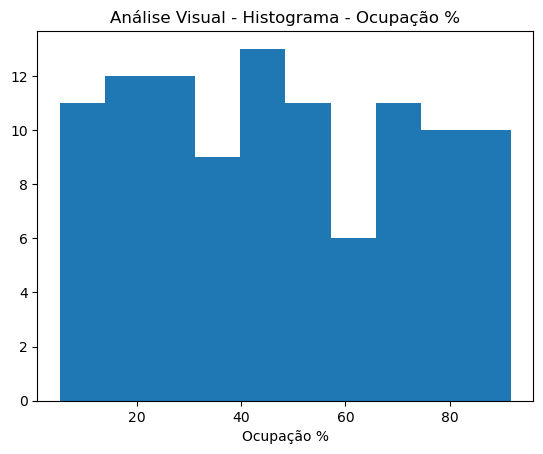

In [79]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [81]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     58
False    47
Name: count, dtype: int64


In [82]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
campeonato_carioca              -0.403100
anunciou_poupar                 -0.363907
temperatura                     -0.341797
eliminatorio                    -0.289547
tipo_partida_volta              -0.254930
estado_adversario_RJ            -0.236182
time_adversario_Portuguesa-RJ   -0.221072
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro                  1.000000
mes                             0.439681
rodada                          0.427245
campeonato_serie a              0.383712
tipo_partida_liga               0.310484
tecnico_botafogo_Artur Jorge    0.250183
colocacao_adversario            0.242190
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [84]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1    56
-1    27
 0    22
Name: count, dtype: int64


In [85]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
tecnico_botafogo_Lúcio Flávio   -0.323211
time_adversario_Flamengo        -0.231833
fase_final                      -0.210428
estado_adversario_MT            -0.191337
time_adversario_Cuiabá-MT       -0.191337
dias_ultimo_jogo_casa           -0.173001
classico                        -0.157067
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida               1.000000
resultados_ultimo_jogo          0.533972
gols_botafogo_ultimos_jogos     0.242146
minuto                          0.214512
tecnico_botafogo_Artur Jorge    0.204148
jogos_no_mes                    0.191769
dia_mes                         0.185826
Name: resultado_partida, dtype: float64


### Modelagem

##### Modelo 1

In [88]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [89]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]
cat_features = X_test.select_dtypes(exclude=[np.number])

In [117]:
parametros = tunning_hiperpametros(CatBoostRegressor, X_train, y_train)

Testando Variáveis: depth, min_data_in_leaf
Testando Variáveis: learning_rate, iterations
Testando Variáveis: subsample, colsample_bylevel
-----------------------------


In [118]:
model = CatBoostRegressor(learning_rate=parametros[3], depth=parametros[0], min_data_in_leaf=parametros[1], iterations=parametros[2], random_state=1,  
                     subsample = parametros[4], colsample_bylevel=parametros[5], verbose=False)

model.fit(X_train, y_train, eval_set=eval_set, use_best_model=True, early_stopping_rounds=10)

In [109]:
model.feature_importances_

array([0.00000000e+00, 4.19231469e+00, 2.70388892e-01, 2.59752321e+00,
       1.96924514e+00, 1.11400834e+00, 3.51727098e-02, 1.05764148e+00,
       1.08131607e-01, 7.27322050e-01, 2.03759752e-01, 2.35408591e+01,
       2.59878881e+00, 2.47125735e-02, 7.64171025e-01, 9.08852841e+00,
       3.85832610e-03, 8.86097228e-01, 8.91761243e-02, 1.16219830e-01,
       1.85584707e-02, 3.62329248e+01, 2.27153124e-02, 2.46958427e+00,
       0.00000000e+00, 0.00000000e+00, 2.11542653e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.06543354e-01, 4.40086800e-02,
       1.98701442e-02, 0.00000000e+00, 1.97496925e-01, 7.70896551e-02,
       2.33730393e-04, 2.87687428e-01, 1.80942085e-02, 3.63313792e-01,
       6.54113980e-02, 5.82584322e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.28872052e-02, 1.06285400e-01,
       1.56886998e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Text(0.5, 1.0, 'Feature Importance')

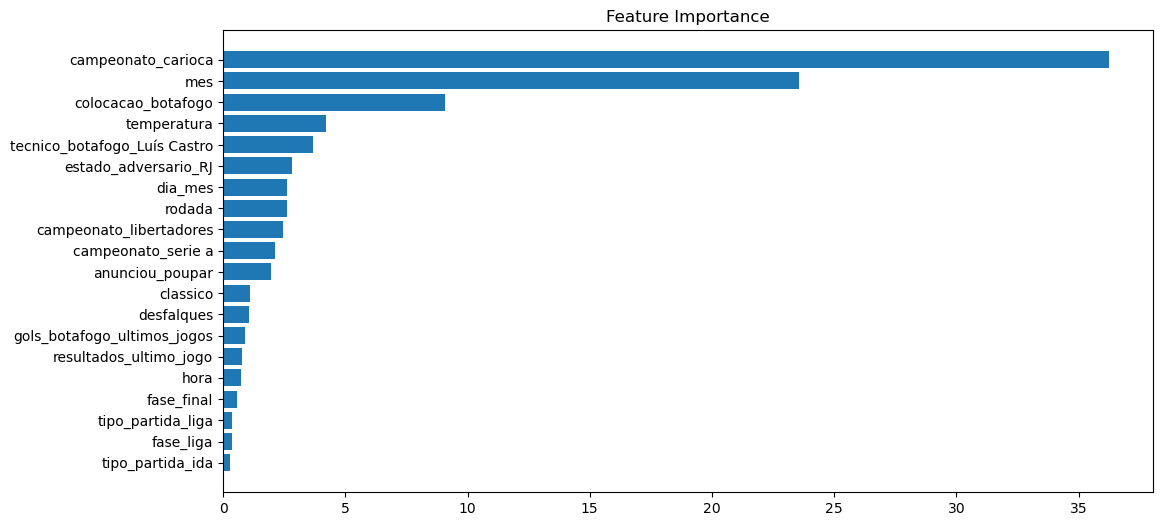

In [111]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [113]:
score = model.score(X_train, y_train)  
score

0.3517773602732416

In [85]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

17

Text(0.5, 1.0, 'Previsão Ocupação')

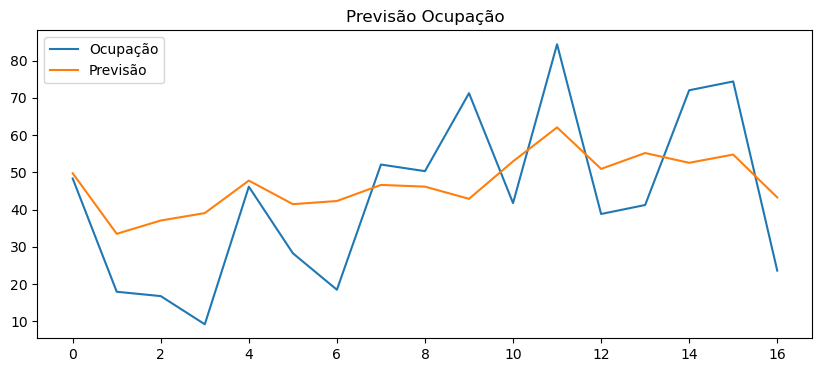

In [86]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [87]:
taxas_erro(y_test, predictions)

Erro médio quadrático:  17.58023020661695
Erro médio absoluto:  15.410588235294119


##### Previsões

In [89]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [90]:
model.predict(dataset_previsao_modelo)

array([49.86806522])

##### Modelo 2

In [92]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [93]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [95]:
tunning_hiperpametros(CatBoostClassifier, X_train, y_train)

Testando Variáveis: max_depth
0:	learn: 0.6892858	total: 7.05ms	remaining: 1.4s
1:	learn: 0.6848308	total: 13.8ms	remaining: 1.36s
2:	learn: 0.6798789	total: 19.7ms	remaining: 1.29s
3:	learn: 0.6765227	total: 26.2ms	remaining: 1.28s
4:	learn: 0.6706100	total: 31.7ms	remaining: 1.24s
5:	learn: 0.6652691	total: 39.2ms	remaining: 1.27s
6:	learn: 0.6603465	total: 44.8ms	remaining: 1.23s
7:	learn: 0.6554262	total: 50.6ms	remaining: 1.21s
8:	learn: 0.6511265	total: 57.9ms	remaining: 1.23s
9:	learn: 0.6462608	total: 63.8ms	remaining: 1.21s
10:	learn: 0.6422322	total: 71.6ms	remaining: 1.23s
11:	learn: 0.6372090	total: 77.5ms	remaining: 1.21s
12:	learn: 0.6330277	total: 82.7ms	remaining: 1.19s
13:	learn: 0.6284562	total: 89.5ms	remaining: 1.19s
14:	learn: 0.6235262	total: 95.8ms	remaining: 1.18s
15:	learn: 0.6196411	total: 102ms	remaining: 1.17s
16:	learn: 0.6145105	total: 108ms	remaining: 1.17s
17:	learn: 0.6089478	total: 112ms	remaining: 1.14s
18:	learn: 0.6034180	total: 119ms	remaining: 1.1

In [96]:
model = CatBoostClassifier(learning_rate=0.01, max_depth=9, n_estimators=10000, random_state=1,  
                     subsample = 0.8)

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1, early_stopping_rounds=10)

0:	learn: 0.6882087	test: 0.6928161	best: 0.6928161 (0)	total: 10ms	remaining: 1m 40s
1:	learn: 0.6819531	test: 0.6925598	best: 0.6925598 (1)	total: 18.6ms	remaining: 1m 32s
2:	learn: 0.6787446	test: 0.6918193	best: 0.6918193 (2)	total: 27.7ms	remaining: 1m 32s
3:	learn: 0.6736022	test: 0.6912400	best: 0.6912400 (3)	total: 36.3ms	remaining: 1m 30s
4:	learn: 0.6686702	test: 0.6901372	best: 0.6901372 (4)	total: 45.7ms	remaining: 1m 31s
5:	learn: 0.6633272	test: 0.6886040	best: 0.6886040 (5)	total: 54.9ms	remaining: 1m 31s
6:	learn: 0.6576886	test: 0.6854018	best: 0.6854018 (6)	total: 63.5ms	remaining: 1m 30s
7:	learn: 0.6519630	test: 0.6840252	best: 0.6840252 (7)	total: 72.1ms	remaining: 1m 30s
8:	learn: 0.6467801	test: 0.6836423	best: 0.6836423 (8)	total: 79ms	remaining: 1m 27s
9:	learn: 0.6427822	test: 0.6821998	best: 0.6821998 (9)	total: 88.1ms	remaining: 1m 27s
10:	learn: 0.6370830	test: 0.6808193	best: 0.6808193 (10)	total: 96.9ms	remaining: 1m 28s
11:	learn: 0.6325597	test: 0.67968

In [97]:
model.feature_importances_

array([2.00258760e+00, 1.01270687e+01, 1.44334667e+00, 5.19608493e+00,
       2.73176395e+00, 2.76632460e+00, 3.50764612e+00, 2.95168130e+00,
       4.56235088e+00, 7.15754959e+00, 4.23007315e+00, 6.13236493e+00,
       2.48147631e+00, 2.27269960e+00, 4.00397553e+00, 7.89323744e+00,
       4.02739653e+00, 2.64276217e+00, 1.72996121e-01, 6.86727609e+00,
       2.14673935e+00, 7.11717774e-06, 1.24957656e-01, 6.60249435e-01,
       7.53369249e-01, 4.29800079e-02, 6.44193515e-03, 2.48192370e-01,
       0.00000000e+00, 1.86848651e-01, 2.50372506e-02, 0.00000000e+00,
       4.46132783e-03, 0.00000000e+00, 4.66485739e+00, 1.31629664e+00,
       4.04671370e-02, 2.10332005e-05, 6.07695887e-03, 0.00000000e+00,
       0.00000000e+00, 7.90836658e-02, 1.32449170e-02, 0.00000000e+00,
       1.86437493e-01, 0.00000000e+00, 7.64605665e-03, 3.24884704e-02,
       2.40915921e-02, 6.06145829e-02, 1.19651542e-01, 4.46338050e-02,
       0.00000000e+00, 2.89428448e-01, 3.20345394e-01, 6.47682570e-02,
      

Text(0.5, 1.0, 'Feature Importance')

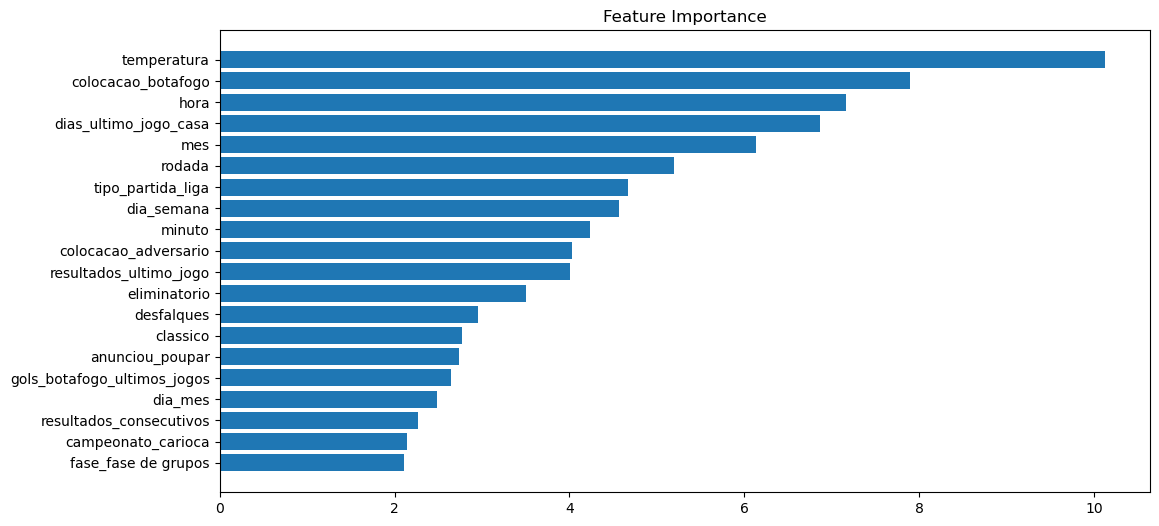

In [98]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [99]:
score = model.score(X_train, y_train)  
score

1.0

In [100]:
y_pred = model.predict(X_test)
predictions = [int(value) for value in y_pred]
len(predictions)

17

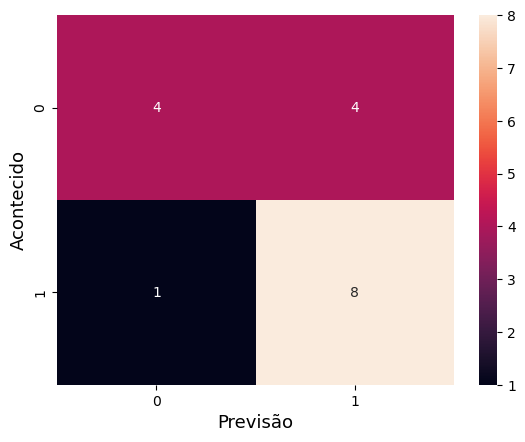

In [101]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [102]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.80      0.50      0.62         8
        True       0.67      0.89      0.76         9

    accuracy                           0.71        17
   macro avg       0.73      0.69      0.69        17
weighted avg       0.73      0.71      0.69        17



##### Previsões

In [104]:
model.predict(dataset_previsao_modelo)

array([ True])

##### Modelo 3

In [106]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [107]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [108]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [110]:
tunning_hiperpametros(CatBoostClassifier, X_train, y_train)

Testando Variáveis: max_depth
0:	learn: 1.0941794	total: 1.94ms	remaining: 387ms
1:	learn: 1.0905037	total: 4.12ms	remaining: 408ms
2:	learn: 1.0865228	total: 5.73ms	remaining: 376ms
3:	learn: 1.0842784	total: 7.48ms	remaining: 366ms
4:	learn: 1.0818359	total: 9.81ms	remaining: 383ms
5:	learn: 1.0796539	total: 11.8ms	remaining: 381ms
6:	learn: 1.0774528	total: 14ms	remaining: 386ms
7:	learn: 1.0757873	total: 16ms	remaining: 384ms
8:	learn: 1.0735968	total: 17.9ms	remaining: 381ms
9:	learn: 1.0712447	total: 19.7ms	remaining: 375ms
10:	learn: 1.0682557	total: 21.4ms	remaining: 367ms
11:	learn: 1.0660435	total: 24.1ms	remaining: 377ms
12:	learn: 1.0637182	total: 26ms	remaining: 374ms
13:	learn: 1.0617571	total: 27.9ms	remaining: 370ms
14:	learn: 1.0596376	total: 29.8ms	remaining: 367ms
15:	learn: 1.0575274	total: 32.2ms	remaining: 371ms
16:	learn: 1.0552755	total: 34ms	remaining: 366ms
17:	learn: 1.0531290	total: 35.7ms	remaining: 361ms
18:	learn: 1.0515259	total: 38ms	remaining: 362ms
19

In [111]:
model = CatBoostClassifier(learning_rate=0.01, max_depth=9, n_estimators=10000, random_state=1)

model.fit(X_train, y_train, eval_set=eval_set, verbose = 1, early_stopping_rounds=10)

0:	learn: 1.0956060	test: 1.0969713	best: 1.0969713 (0)	total: 14.1ms	remaining: 2m 21s
1:	learn: 1.0933984	test: 1.0959088	best: 1.0959088 (1)	total: 19.7ms	remaining: 1m 38s
2:	learn: 1.0909542	test: 1.0950566	best: 1.0950566 (2)	total: 35.1ms	remaining: 1m 56s
3:	learn: 1.0881008	test: 1.0934145	best: 1.0934145 (3)	total: 50ms	remaining: 2m 5s
4:	learn: 1.0850463	test: 1.0912478	best: 1.0912478 (4)	total: 61ms	remaining: 2m 1s
5:	learn: 1.0819650	test: 1.0908479	best: 1.0908479 (5)	total: 75.1ms	remaining: 2m 5s
6:	learn: 1.0794326	test: 1.0894390	best: 1.0894390 (6)	total: 94.1ms	remaining: 2m 14s
7:	learn: 1.0773719	test: 1.0882317	best: 1.0882317 (7)	total: 109ms	remaining: 2m 16s
8:	learn: 1.0753602	test: 1.0877473	best: 1.0877473 (8)	total: 124ms	remaining: 2m 17s
9:	learn: 1.0731565	test: 1.0871372	best: 1.0871372 (9)	total: 137ms	remaining: 2m 16s
10:	learn: 1.0714039	test: 1.0859488	best: 1.0859488 (10)	total: 149ms	remaining: 2m 15s
11:	learn: 1.0690305	test: 1.0844191	best

In [112]:
model.feature_importances_

array([3.93849915e+00, 4.23269606e+00, 4.33744056e+00, 4.46448098e+00,
       6.55110975e-02, 2.79374315e+00, 9.08980442e-01, 6.90378819e+00,
       5.59696440e+00, 3.24725625e+00, 2.16043805e+00, 4.66725560e+00,
       7.72576035e+00, 3.54298356e+00, 1.01425399e+01, 3.40158148e+00,
       3.11324907e+00, 6.68298940e+00, 2.43863866e-01, 7.61775560e+00,
       4.23564049e-01, 2.03222184e-01, 2.51769294e-01, 5.08560036e-01,
       1.65613540e+00, 1.02541771e-04, 2.91676062e-03, 1.58501938e-01,
       8.67426445e-04, 3.91670608e-01, 8.89274245e-02, 0.00000000e+00,
       9.34930389e-02, 0.00000000e+00, 7.88683419e-01, 2.33843157e-01,
       3.19399045e-01, 1.05092453e-02, 4.57541347e-03, 0.00000000e+00,
       2.58393391e-02, 1.06509632e-01, 3.60297076e-02, 2.66016376e-02,
       6.76943660e-02, 1.51364399e-01, 1.02223867e-01, 4.27493214e-03,
       1.80692327e-02, 1.23194757e-01, 5.20982135e-01, 8.35214902e-02,
       1.06248645e-02, 3.20281493e-01, 6.17311618e-01, 3.05675726e-01,
      

Text(0.5, 1.0, 'Feature Importance')

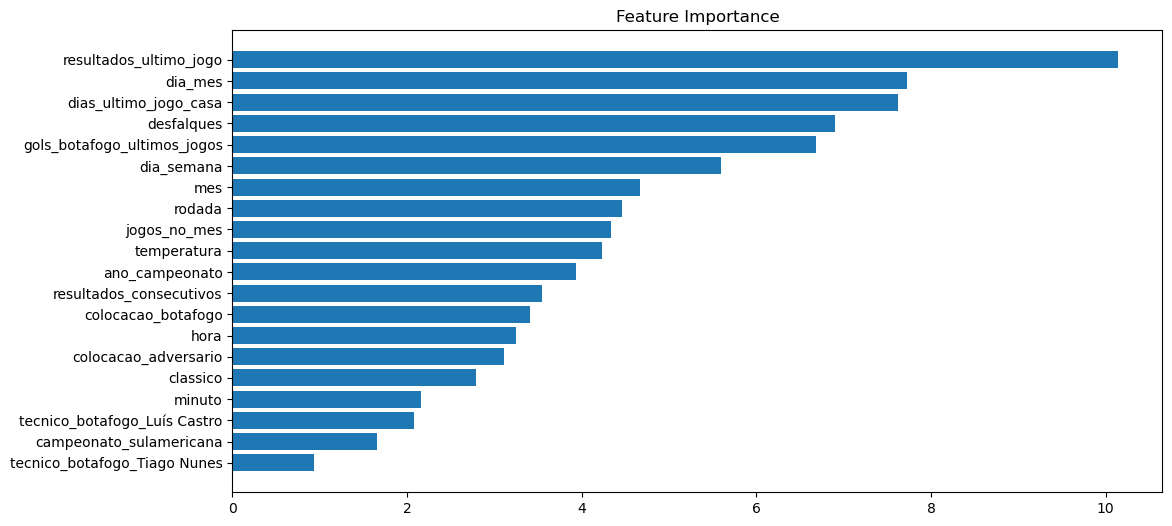

In [113]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(20), feature_importance[sorted_idx][-20:], align='center')
plt.yticks(range(20), np.array(X_test.columns)[sorted_idx][-20:])
plt.title('Feature Importance')

In [114]:
score = model.score(X_train, y_train)  
score

0.9701492537313433

In [115]:
y_pred = model.predict(X_test)
predictions = [int(value) for value in y_pred]
len(predictions)

17

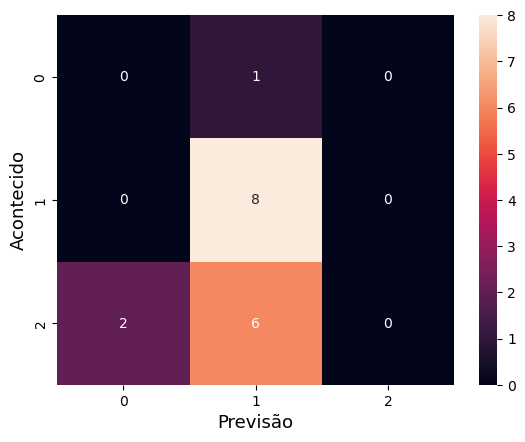

In [116]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Acontecido',fontsize=13)
plt.xlabel('Previsão',fontsize=13)
plt.show()

In [117]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.53      1.00      0.70         8
           2       0.00      0.00      0.00         8

    accuracy                           0.47        17
   macro avg       0.18      0.33      0.23        17
weighted avg       0.25      0.47      0.33        17



##### Previsões

In [119]:
model.predict(dataset_previsao_modelo)

array([[2]], dtype=int64)